
# ARIMA 
Abhishek Gopinath K CB.EN.P2AID20002

In [41]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [43]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [44]:
df.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [45]:
df.columns=["Month","Sales"]
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [46]:
df.dropna(inplace=True)

In [47]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])

In [48]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [49]:
df.set_index('Month',inplace=True)

In [50]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [51]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


#  Visualize the Data

<AxesSubplot:xlabel='Month'>

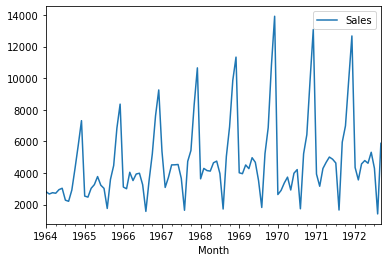

In [52]:
df.plot()

# Analysing seasonality

## Multiplicative Decomposition 

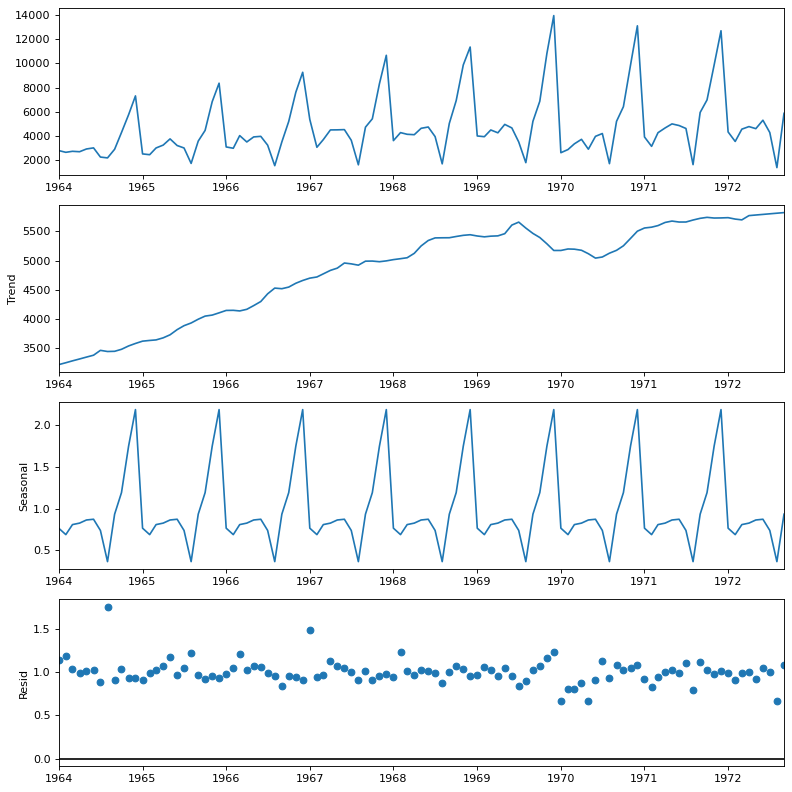

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Plot
plt.rcParams.update({'figure.figsize': (10,10), 'figure.dpi' : 80})
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df, model='multiplicative', extrapolate_trend='freq')
result_mul.plot()
plt.show()

## Additive Decomposition

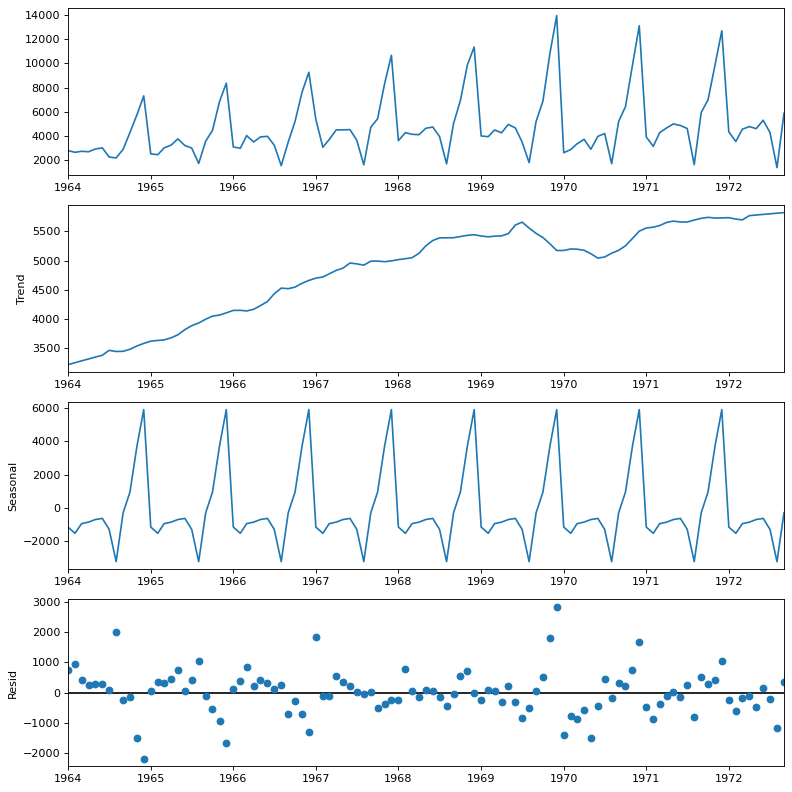

In [54]:
result_add = seasonal_decompose(df, model='additive', extrapolate_trend='freq')
result_add.plot()
plt.show()

- If you look at the residuals of the additive decomposition closely, it has some pattern left over. 
- The multiplicative decomposition, however, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

# Checking for stationarity using ADF

We can see from the graph that the data is non-stationary. To check for stationarity we will use adfuller.

In [55]:
from statsmodels.tsa.stattools import adfuller

In [56]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [57]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276126
p-value : 0.36391577166025
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# Differencing

In [58]:
df.diff()

,Sales
Month,
1964-01-01,NaN
1964-02-01,-143.0
1964-03-01,83.0
1964-04-01,-34.0
1964-05-01,225.0
...,...
1972-05-01,-170.0
1972-06-01,694.0
1972-07-01,-1014.0


In [59]:
adfuller_test(df.diff().dropna())

ADF Test Statistic : -7.189896448051009
p-value : 2.5196204473869244e-10
#Lags Used : 11
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

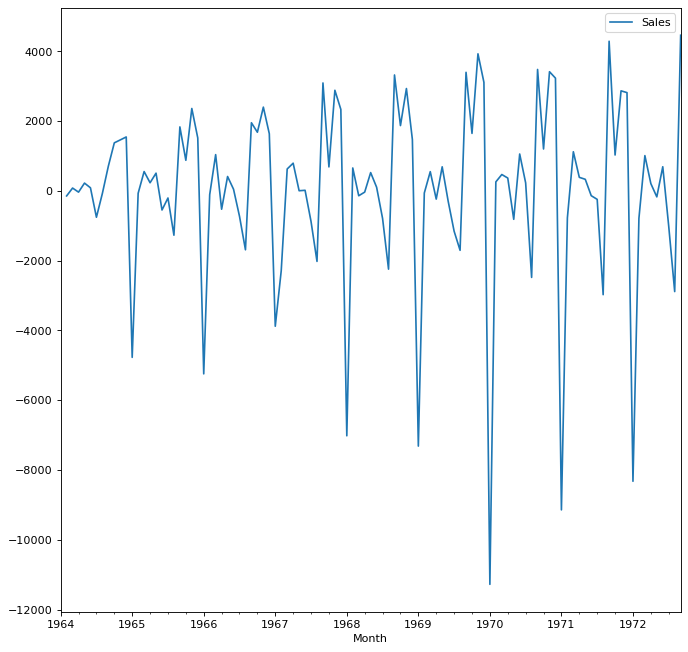

In [60]:
df.diff().plot()

We get a singnificance valueless than 0.05 hence we can take **d = 1**

# Autocorrelation and Partial Autocorrelation

    p AR model lags
    d differencing
    q MA lags

In [61]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

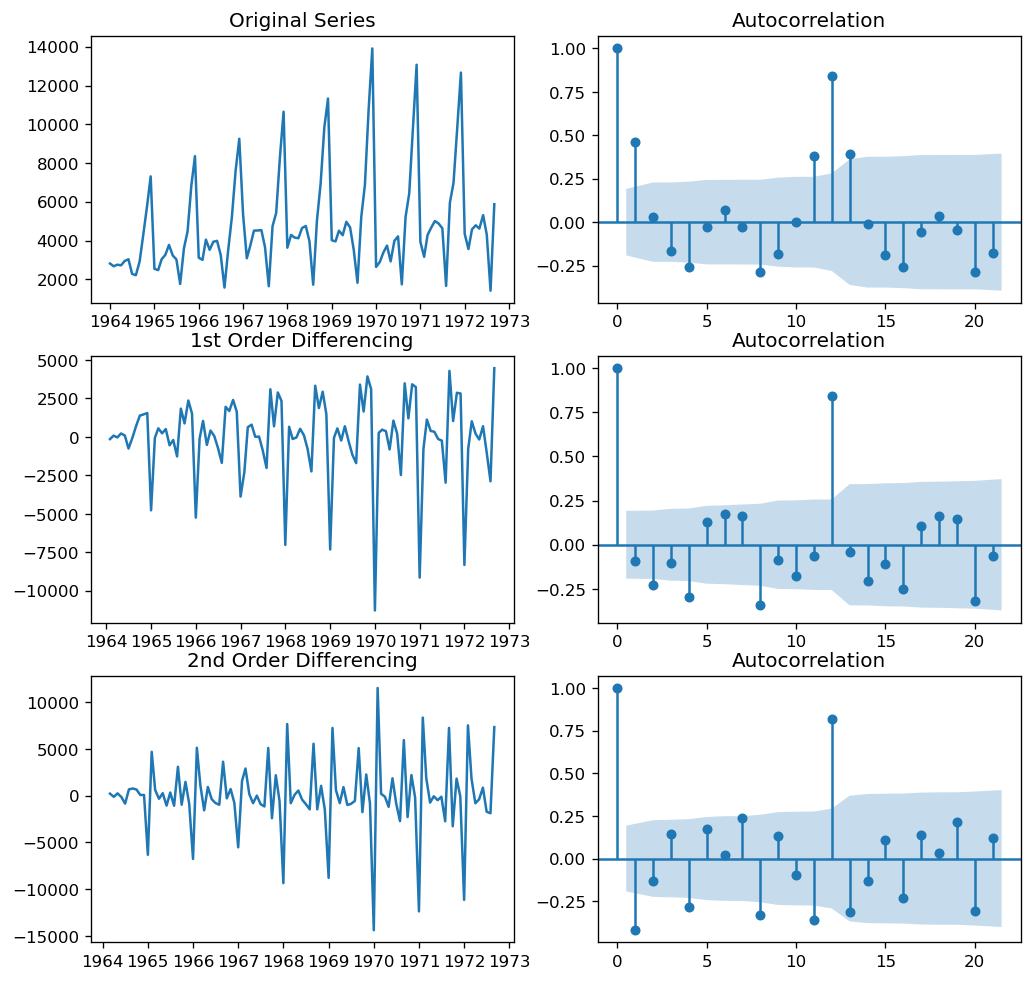

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

- After one differecne We can see that lag 2 is silightly significant in the ACF plot. Hence taking **q as 2**

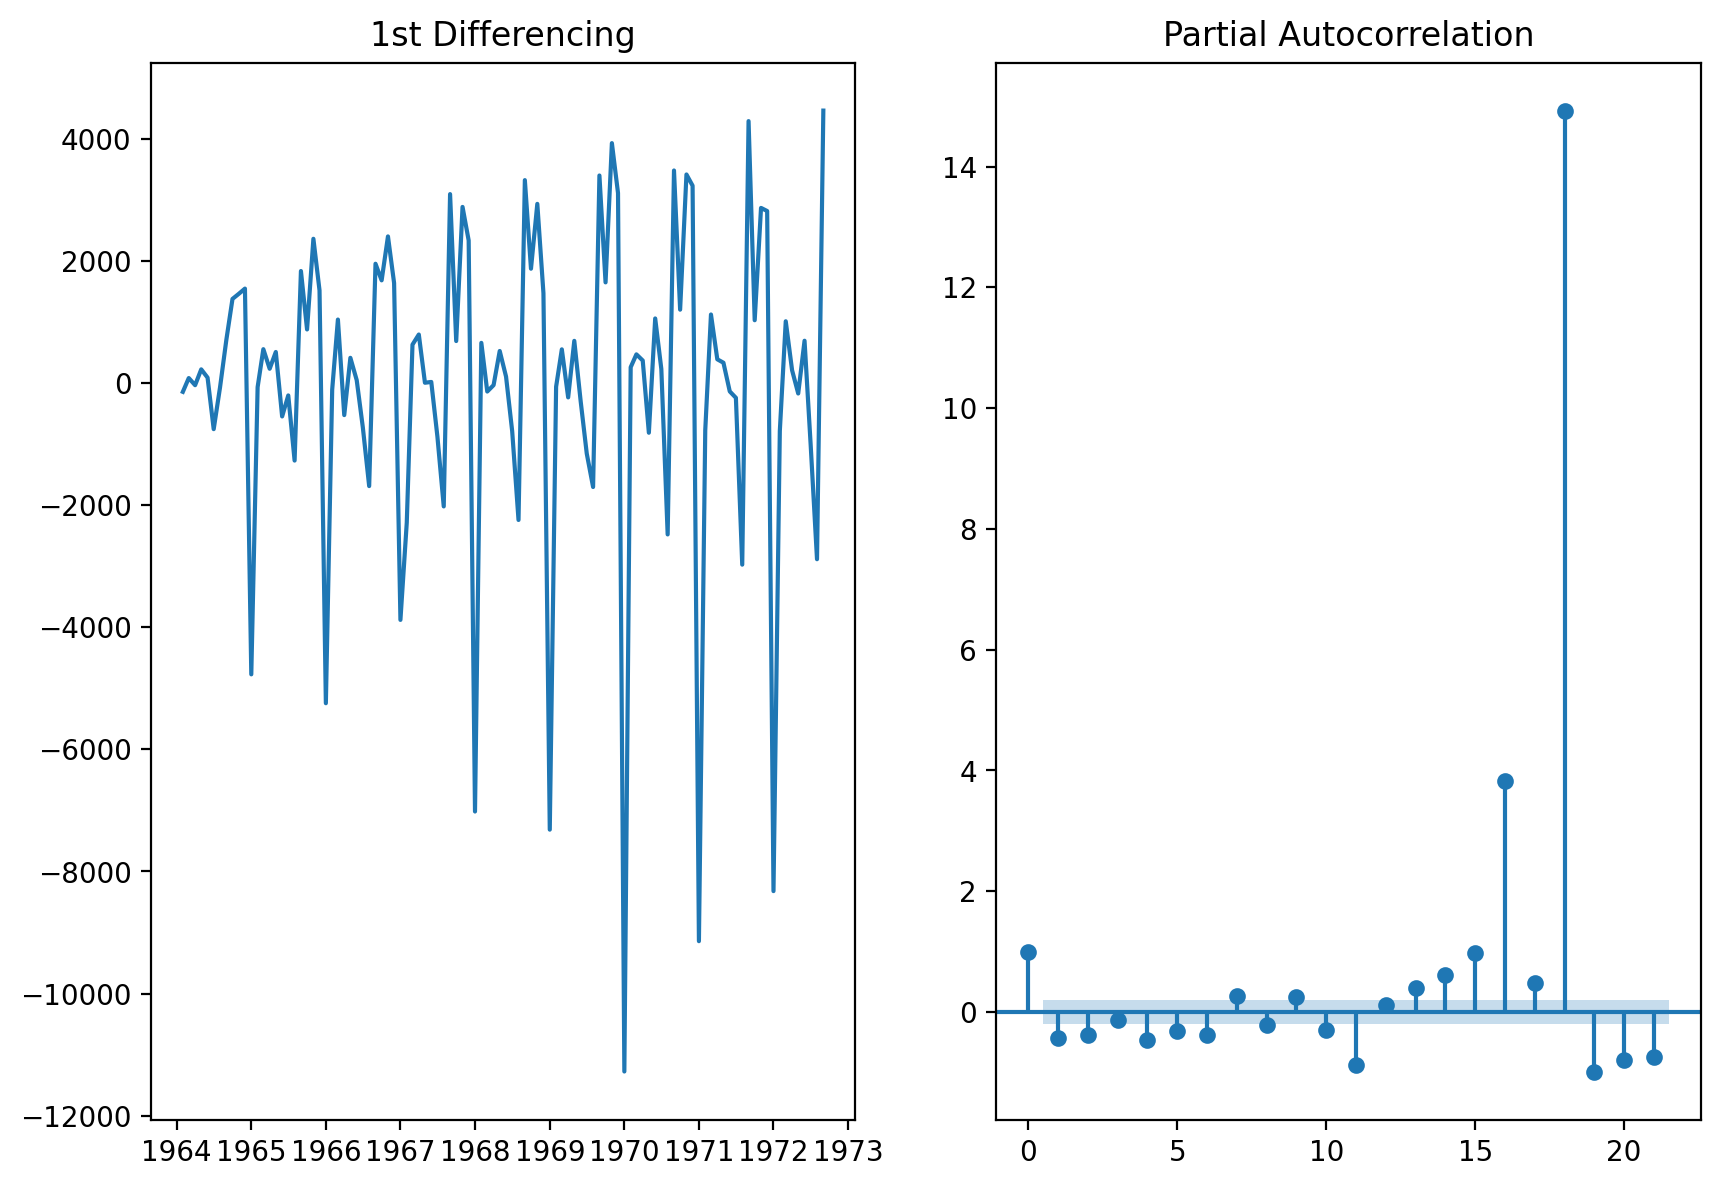

In [63]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':200})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.diff().dropna()); axes[0].set_title('1st Differencing')
plot_pacf(df.diff().diff().dropna(), ax=axes[1])

plt.show()

- After one difference We can see that lag 1 is quite significant in the PACF plot. Hence taking **p as 1**.

# Building the ARIMA model

In [64]:
from statsmodels.tsa.arima_model import ARIMA

Initially taking p,d,q as 1,1,1

In [65]:
model=ARIMA(df,order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Fri, 11 Jun 2021   AIC                           1910.251
Time:                        20:19:32   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7853     12.405      1.837      0.066      -1.528      47.099
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Now taking p,d,q as 1,1,2

In [66]:
model=ARIMA(df,order=(1,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -946.496
Method:                       css-mle   S.D. of innovations           2121.880
Date:                Fri, 11 Jun 2021   AIC                           1902.993
Time:                        20:19:33   BIC                           1916.215
Sample:                    02-01-1964   HQIC                          1908.349
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            23.1714      9.973      2.323      0.020       3.625      42.718
ar.L1.D.Sales    -0.2231      0.132     -1.694      0.090      -0.481       0.035
ma.L1.D.Sales    -0.2015      0.083     -2.418      0.016      -0.365      -0.038
ma.L2.D.Sales    -0.7985      0.082     -9.778      0.000      -0.959      -0.638
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.4817           +0.0000j            4.4817            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.2523           +0.0000j            1.2523            0.5000
-----------------------------------------------------------------------------
"""

We can see a p value greater than 0.05 hence taking **d = 2**. Refitting the model

In [67]:
model=ARIMA(df,order=(1,2,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Sales   No. Observations:                  103
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -946.353
Method:                       css-mle   S.D. of innovations           2236.982
Date:                Fri, 11 Jun 2021   AIC                           1902.705
Time:                        20:19:33   BIC                           1915.879
Sample:                    03-01-1964   HQIC                          1908.041
                         - 09-01-1972                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8995      1.314     -0.684      0.494      -3.475       1.676
ar.L1.D2.Sales     0.4381      0.092      4.760      0.000       0.258       0.618
ma.L1.D2.Sales    -1.9966      0.036    -55.542      0.000      -2.067      -1.926
ma.L2.D2.Sales     1.0000      0.035     28.261      0.000       0.931       1.069
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2826           +0.0000j            2.2826            0.0000
MA.1            0.9983           -0.0583j            1.0000           -0.0093
MA.2            0.9983           +0.0583j            1.0000            0.0093
-----------------------------------------------------------------------------
"""

Hence concluded manually that 
- p is 1 
- d is 2
- q is 2 

# Plotting residuals

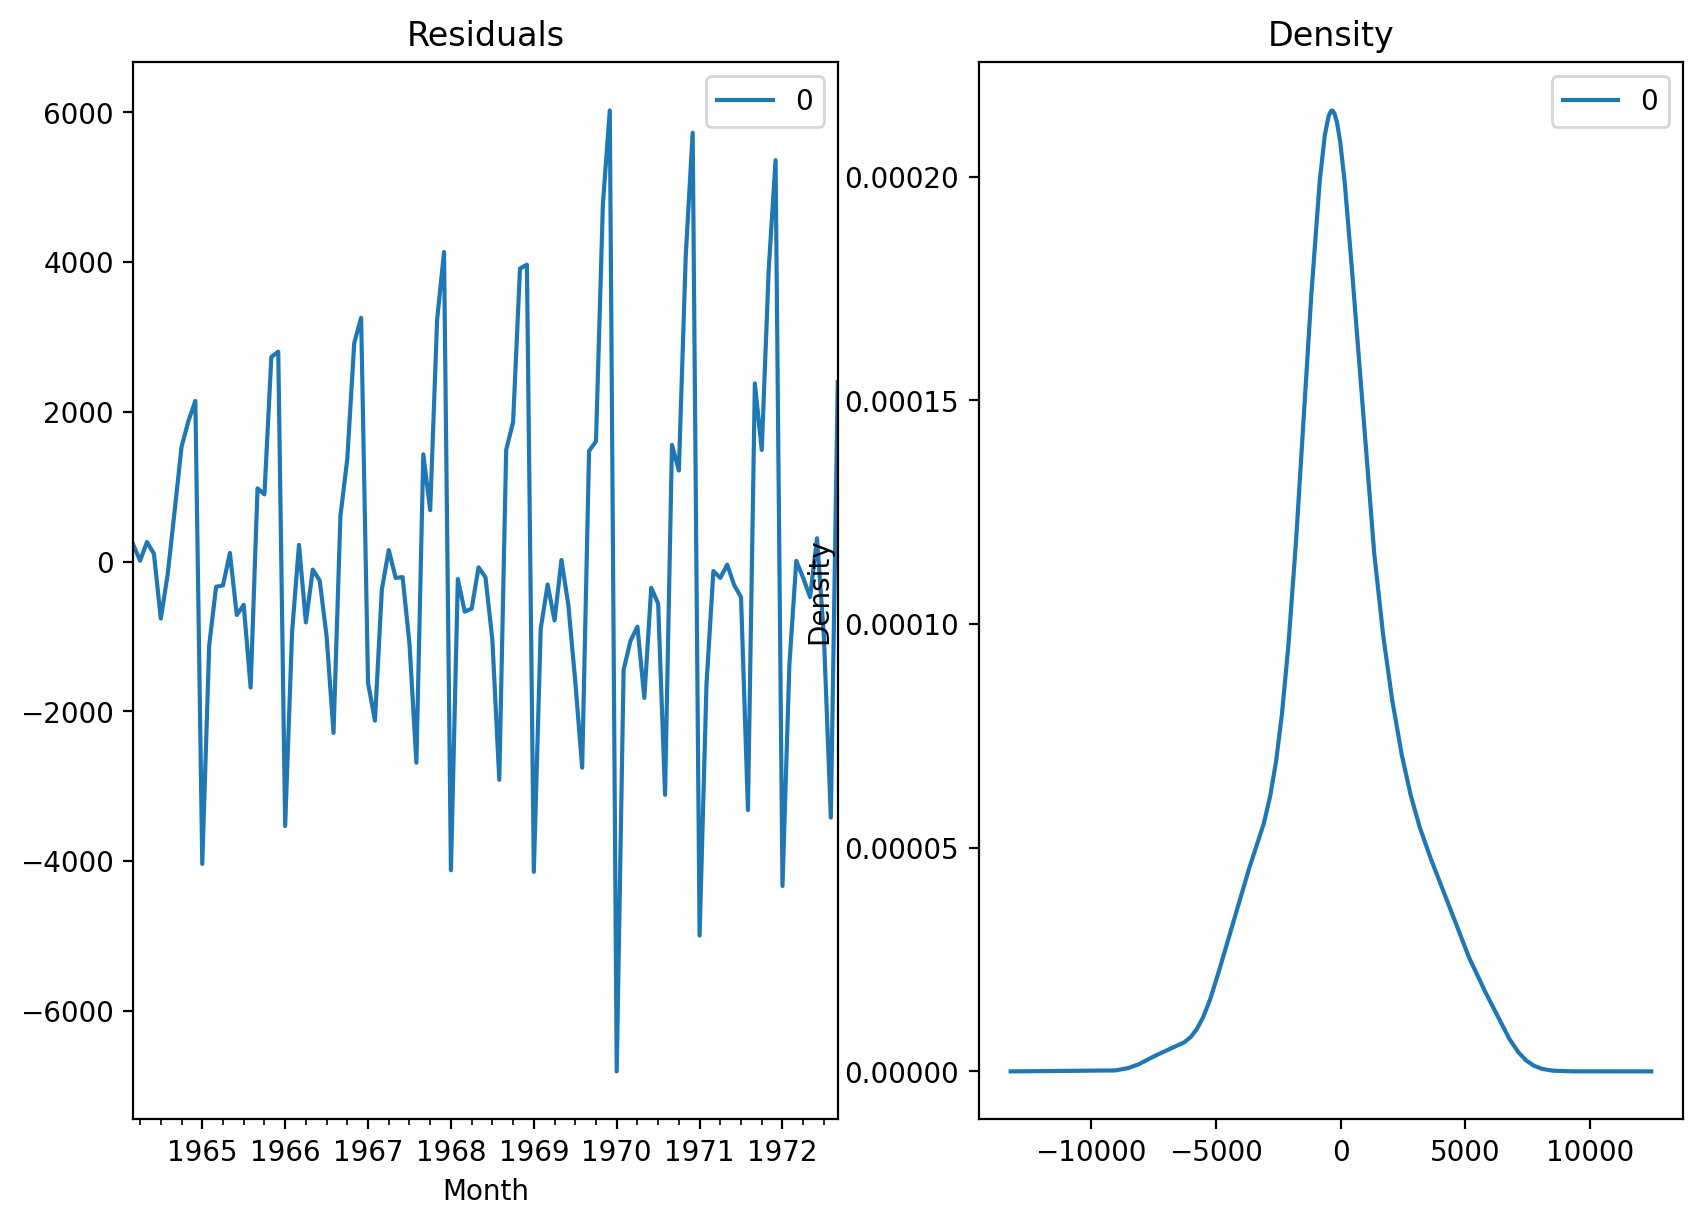

In [68]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Finding optimal ARIMA model using out of time cross validation

In [69]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return({'mape':mape})

plt.style.use('fast')
df.shape

(105, 1)

In [70]:
train = df.iloc[:80]
test = df.iloc[80:]

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -716.780
Method:                       css-mle   S.D. of innovations           2064.811
Date:                Fri, 11 Jun 2021   AIC                           1441.559
Time:                        20:19:34   BIC                           1451.037
Sample:                    02-01-1964   HQIC                          1445.356
                         - 08-01-1970                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            24.0822     18.259      1.319      0.187     -11.704      59.868
ar.L1.D.Sales     0.4693      0.103      4.545      0.000       0.267       0.672
ma.L1.D.Sales    -1.0000      0.036    -

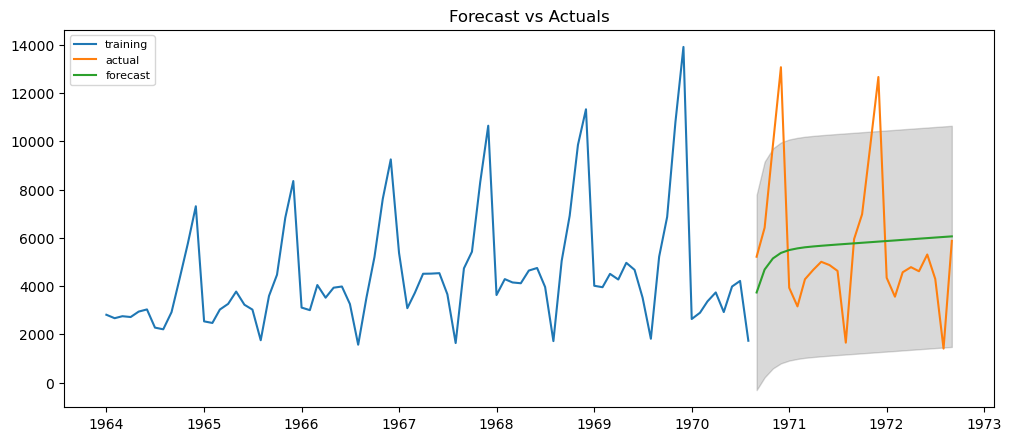

In [71]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [72]:
forecast_accuracy(fc, test.Sales)

{'mape': 0.5244253242633592}

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   79
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -711.636
Method:                       css-mle   S.D. of innovations           1916.583
Date:                Fri, 11 Jun 2021   AIC                           1437.272
Time:                        20:19:35   BIC                           1453.858
Sample:                    02-01-1964   HQIC                          1443.917
                         - 08-01-1970                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            27.3487     10.035      2.725      0.006       7.680      47.018
ar.L1.D.Sales     0.5098      0.113      4.504      0.000       0.288       0.732
ar.L2.D.Sales    -0.2437      0.125     

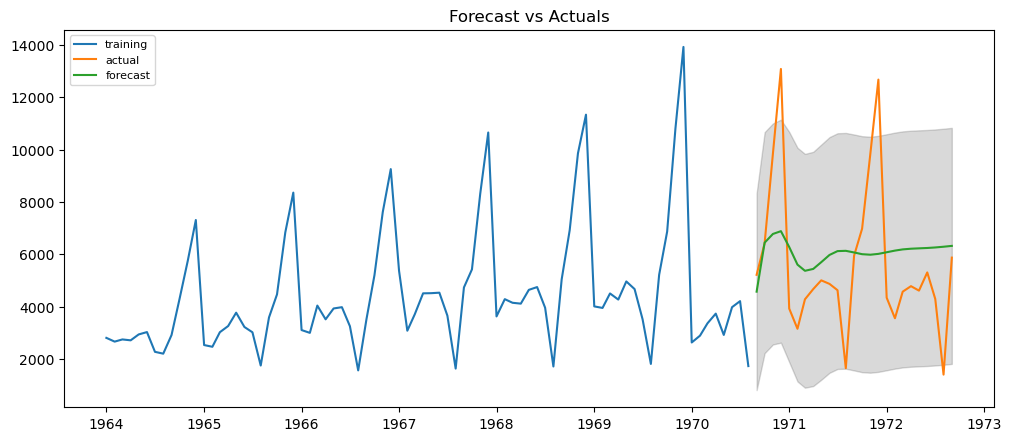

In [73]:
model = ARIMA(train, order=(4, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

- After increaing p and q throught 1 to 5 got a result of p,d,q = 4, 1, 1 

# Carry out automatic ARIMA forecast

In [74]:
model_arima= pm.auto_arima(df.Sales,
                           trace=True, 
                           error_action='ignore', 
                           test='adf',
                           start_p=1,
                           max_p=5,
                           start_q=1,
                           max_q=5,
                           d=1,
                           suppress_warnings=True,
                           stepwise=True,
                           seasonal=False)
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1937.732, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1938.874, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1937.889, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1935.750, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.205 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -966.875
Date:                Fri, 11 Jun 2021   AIC                           1935.750
Time:                        20:19:35   BIC                           1938.394
Sample:                             0   HQIC                          1936.821
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.895e+06   5.29e+05     13.025      0.000    5.86e+06    7.93e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):               139.51
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Carry out a final forecast using the best ARIMA model

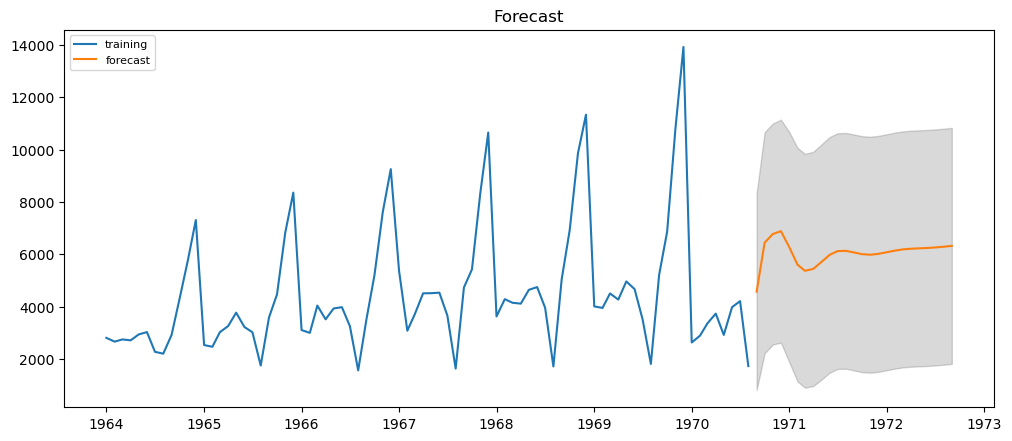

In [75]:
model = ARIMA(train, order=(4, 1, 1))  
fitted = model.fit(disp=0)  

fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Trying SARIMAX
Since there is a seasonality in the data as we can observe from the plots.

In [76]:
import statsmodels.api as sm

In [77]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [78]:
fc = results.predict(start = 104, end = 120, dynamic= True)
fc_series = pd.Series(fc)

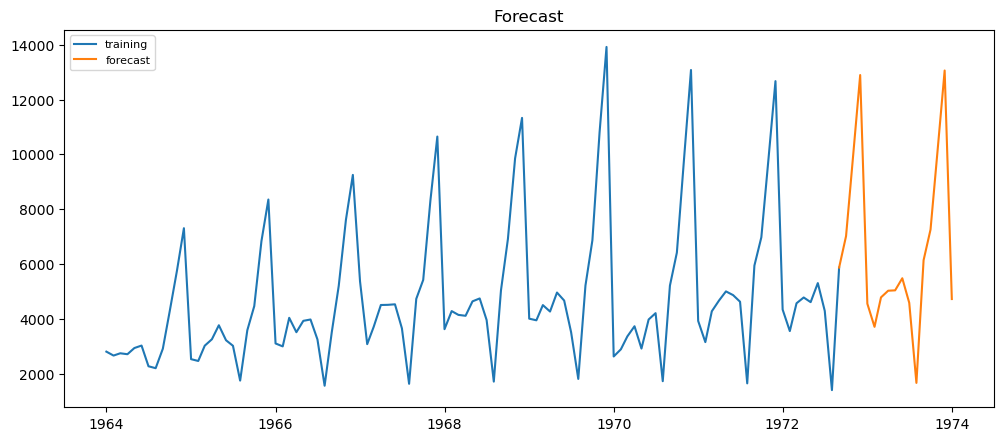

In [79]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='training')
plt.plot(fc_series, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()